In [2]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white', {'xtick.bottom': True, 'ytick.left': True})
sns.set_context('notebook', font_scale=2)

%load_ext autoreload
%autoreload 2

os.chdir("../")

## Baseline with backward Euler

In [156]:
# result_path = "../../noise_std_0.5_pos_weight_5_l2_pen_0.001_patience_5/RESULT/STSPNet/STSPNet_A_1.pkl"
# result_path = "RESULT/STPNet/STPNet_A_1.pkl"
result_path = "RESULT/STPENet/STPENet_A_1.pkl"
temp = pickle.load(open(result_path, 'rb'))


In [157]:
model_data = temp
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

img_bs = 8 - image # index starting at 0
# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

In [158]:
batchind = 0

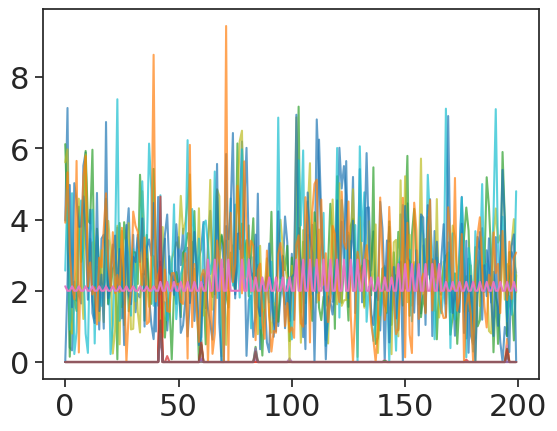

In [159]:
batchind += 1
plt.plot(hidden_act[batchind,:,:], alpha=0.7);
plt.plot(img_bs[batchind,:] / 8 + 2);

In [160]:
cellind = 0

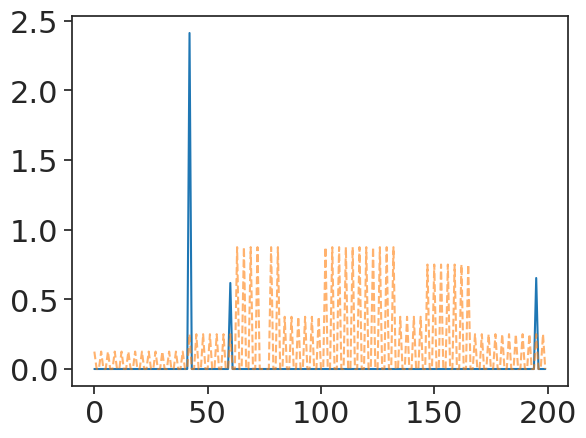

In [161]:
# batchind+=1
cellind  += 1
plt.plot(hidden_act[batchind, :, cellind])
plt.plot(img_bs[batchind,:] / 8, alpha=0.6, linestyle="--");

Text(0, 0.5, 'units')

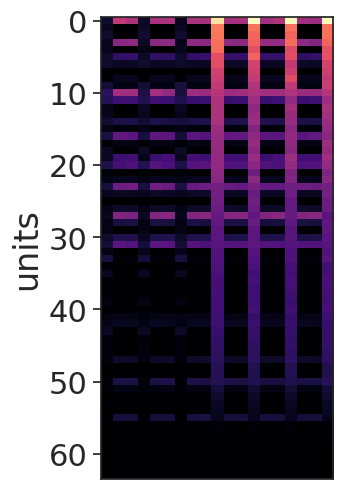

In [162]:
model_data = temp
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)
# print(idx)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'a.u.')

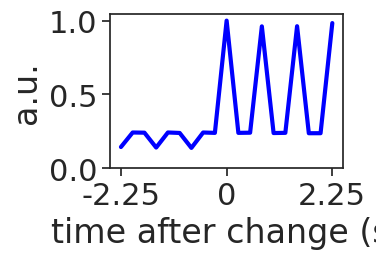

In [163]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color='blue', linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)

plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
# ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')


In [164]:
model_labels = model_data['labels']

# store number of repeats
n_reps = np.zeros_like(model_labels[:, ::3]).squeeze()

# iterate over batches
for b in range(model_labels.shape[0]):
    cnt = -1
    # iterate over flashes
    for i, label in enumerate(model_labels[b, ::3]):
        cnt+=1
        if label==1:
            cnt=0
        n_reps[b, i] = cnt
        
n_reps += 1

In [165]:
data = model_data['hidden']  # choose either input layer or hidden layer
num_cells = data.shape[2]

# Get cell flashes (ignore initial set of flashes)
cell_flash = data[:, 12::3].reshape(-1, num_cells)

# remove omitted flashes
img_model = model_data['image'][:, 12::3].flatten()
cell_flash = cell_flash[img_model!=8]

# first remove first 12 flashes, then omitted flashes
n_reps = n_reps[:, 4:].flatten()
n_reps = n_reps[img_model!=8]

# remove omitted flashes
img_model = img_model[img_model!=8]

In [166]:
# Define mapping between image index and image label
stim_dict_new = {0: 'im077', 1: 'im062', 2: 'im066', 3: 'im063', 4: 'im065', 5: 'im069', 6: 'im085', 7: 'im061', 8: 'blank'}

In [167]:
from sklearn.decomposition import PCA

In [168]:
pca = PCA(n_components=num_cells)

X_pca = pca.fit(cell_flash).transform(cell_flash)

model_df = pd.DataFrame({'image_name': [stim_dict_new[item] for item in img_model], 'repeat': n_reps})
for comp in range(3):
    model_df['pca'+str(comp+1)] = X_pca[:,comp]
    
model_df['pca_distance'] = np.linalg.norm(model_df.loc[:, model_df.columns[2:]].values, axis=1)
model_df['distance'] = np.linalg.norm(cell_flash, axis=1)
model_df['pca1_distance'] = np.abs(model_df.loc[:, model_df.columns[2]].values)
model_df['pca2_distance'] = np.abs(model_df.loc[:, model_df.columns[3]].values)

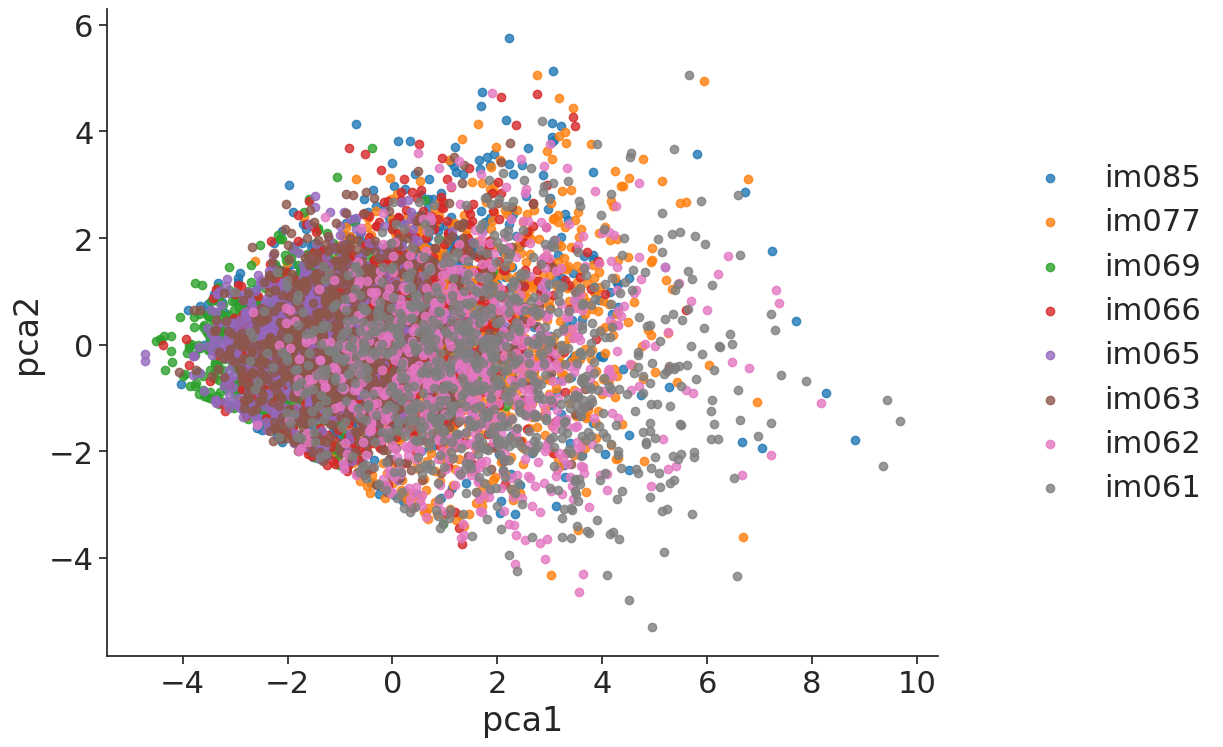

In [169]:
fig = sns.lmplot(
               data=model_df,
        x ='pca1',
        y ='pca2',
        hue='image_name',
           hue_order=sorted(model_df['image_name'].unique(),reverse=True),
           fit_reg=False,
           legend=False,
           height=8,
           aspect=10./8,
        )

plt.legend(frameon=False, loc='right', bbox_to_anchor=(1.35, 0.5))

# save figure
# fig.savefig('figures/stpnet_image_pca_new.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_13505/1019233479.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in fig.ax.get_legend().legendHandles:


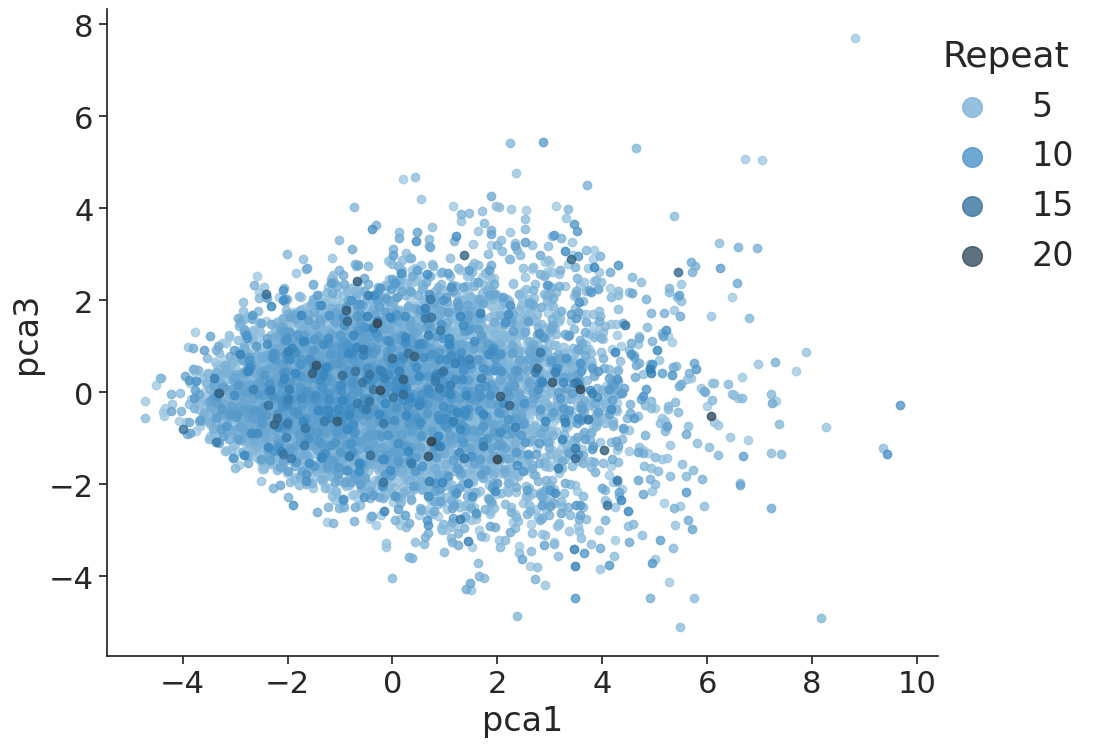

In [170]:
fig = sns.lmplot(
           data=model_df,
           x ='pca1',
        #    y='pca2',
           y='pca3',
           hue='repeat',
           fit_reg=False,
           legend=False,
           height=8,
           aspect=10./8,
           palette='Blues_d',
          )

handles, labels = fig.ax.get_legend_handles_labels()            

idx = np.array([0]+np.arange(4,20,5))
handles = [handles[i] for i in idx]
labels = [int(float(labels[i])) for i in idx]
plt.legend(handles, labels, title='Repeat', frameon=False, loc='upper right', fontsize=24, bbox_to_anchor=(1.2, 1.0))  # , bbox_to_anchor=(1.35, 0.5))

fig.ax.get_legend().get_title().set_fontsize(26) #legend 'Title' fontsize
for lh in fig.ax.get_legend().legendHandles:
    lh.set_sizes([200])

# save figure
# fig.savefig('figures/stpnet_repeat_pca_new.png', dpi=300, bbox_inches='tight')

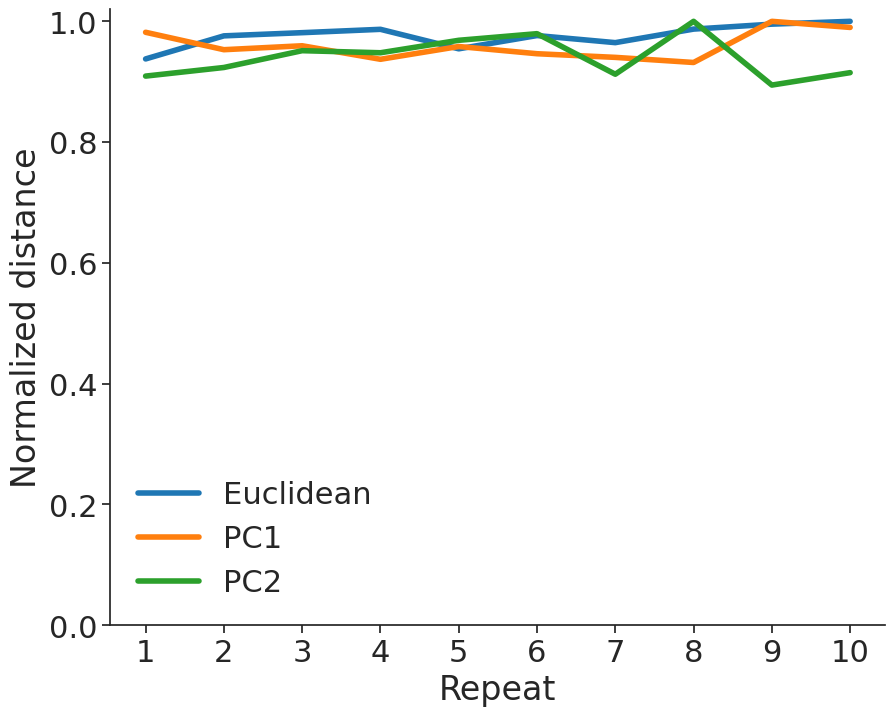

In [171]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

euclidean_distance = model_df.groupby('repeat')['distance'].mean().values[:10]
pca_1_distance = model_df.groupby('repeat')['pca1_distance'].mean().values[:10]
pca_2_distance = model_df.groupby('repeat')['pca2_distance'].mean().values[:10]

ax.plot(np.arange(1,11), euclidean_distance / euclidean_distance.max(), linewidth=4)
ax.plot(np.arange(1,11), pca_1_distance / pca_1_distance.max(), linewidth=4)
ax.plot(np.arange(1,11), pca_2_distance / pca_2_distance.max(), linewidth=4)

ax.set_ylim([0, 1.02])
ax.set_xticks(np.arange(1, 11))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Repeat')
ax.set_ylabel('Normalized distance')
plt.legend(['Euclidean', 'PC1', 'PC2'], frameon=False)

# save figure
# plt.savefig('figures/stpnet_distance.png', dpi=300, bbox_inches='tight')

## STPENet

In [49]:
result_path = "RESULT/STPENet/STPENet_A_2.pkl"
model_data = pickle.load(open(result_path, 'rb'))

Text(0, 0.5, 'units')

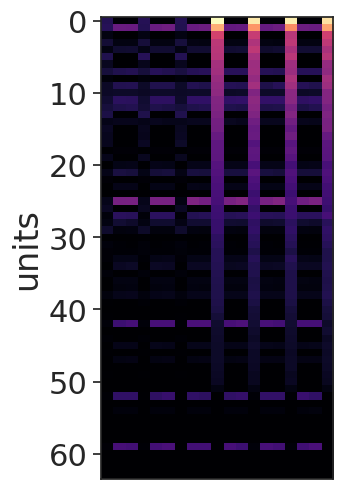

In [58]:
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
# go_trial = np.stack(go_trial).mean(axis=0).transpose()

go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'a.u.')

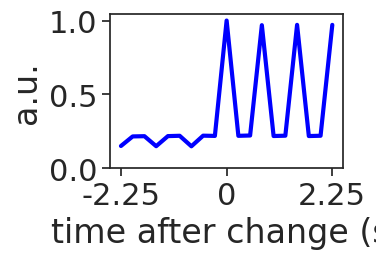

In [57]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color=colors[1], linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
# ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')

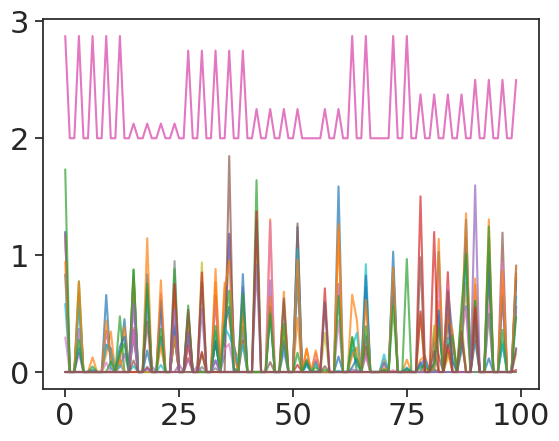

In [56]:
batchind += 1
plt.plot(hidden_act[batchind,:100,:], alpha=0.7);
plt.plot(img_bs[batchind,:100] / 8 + 2);

## RNN

In [ ]:
result_path = "RESULT/RNN/RNN_A_4.pkl"
temp = pickle.load(open(result_path, 'rb'))

In [ ]:
plt.imshow(temp['confusion_matrix'])
plt.colorbar()
plt.clim(0, 1)

In [ ]:
model_data = temp
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
# go_trial = np.stack(go_trial).mean(axis=0).transpose()

go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color=colors[1], linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')


## STPNet with adaptation proportional to  *inverse* error

In [45]:
result_path = "RESULT/STPENet/STPENet_A_4.pkl"
temp = pickle.load(open(result_path, 'rb'))

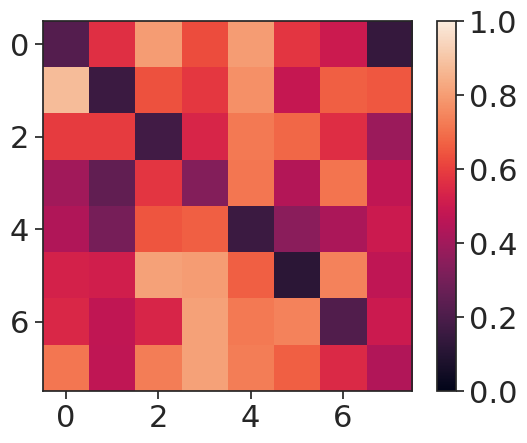

In [46]:
plt.imshow(temp['confusion_matrix'])
plt.colorbar()
plt.clim(0, 1)

Text(0, 0.5, 'units')

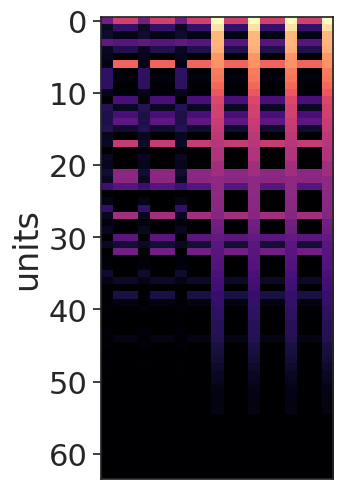

In [47]:
model_data = temp
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
# go_trial = np.stack(go_trial).mean(axis=0).transpose()

go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'a.u.')

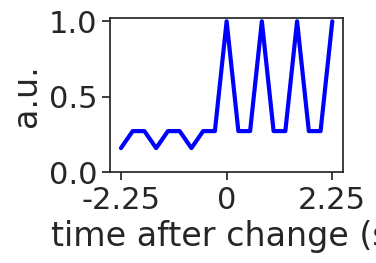

In [48]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color=colors[1], linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')


## STPNet with adaptation proportional to error

In [12]:
result_path = "RESULT/STPENet/STPENet_A_5.pkl"
temp = pickle.load(open(result_path, 'rb'))

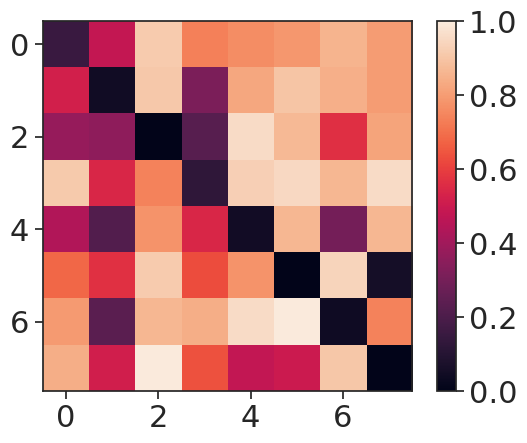

In [13]:
plt.imshow(temp['confusion_matrix'])
plt.colorbar()
plt.clim(0, 1)

Text(0, 0.5, 'units')

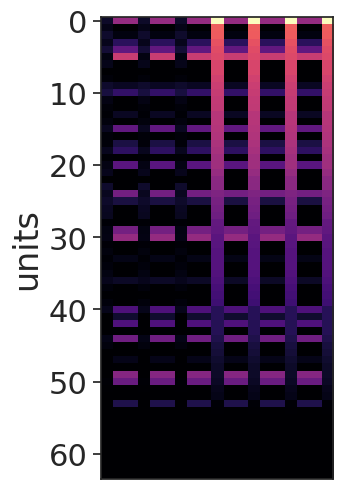

In [14]:
model_data = temp
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
# go_trial = np.stack(go_trial).mean(axis=0).transpose()

go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'a.u.')

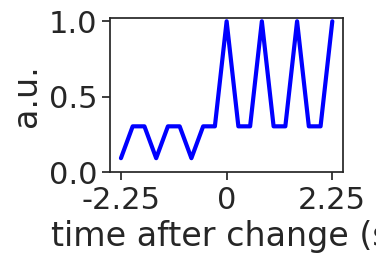

In [15]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color=colors[1], linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')


## Pred Err RNN

In [ ]:
temp_path = "RESULT/STPENet/STPENet_A_3.pkl"
model_data = pickle.load(open(temp_path, 'rb'))

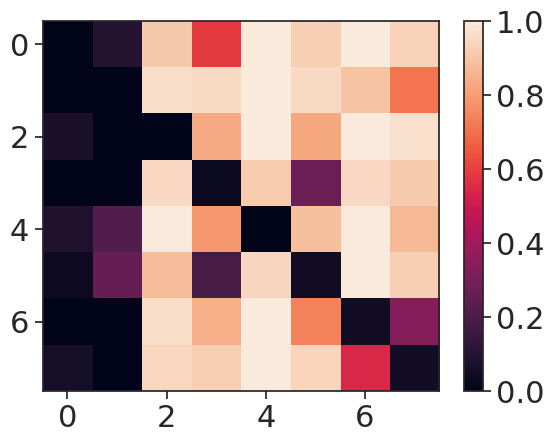

In [6]:
plt.imshow(model_data['confusion_matrix'], aspect="auto")
plt.colorbar()
plt.clim(0, 1)

Text(0, 0.5, 'units')

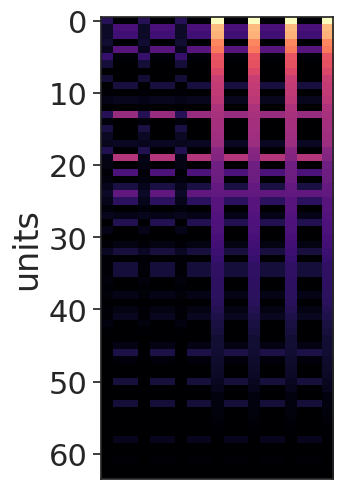

In [4]:
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
# go_trial = np.stack(go_trial).mean(axis=0).transpose()

go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'a.u.')

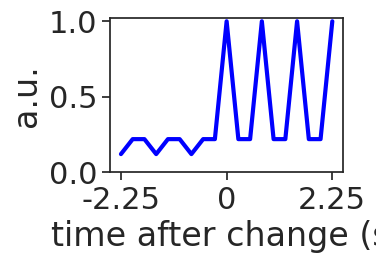

In [5]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color=colors[1], linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')
